In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score

In [74]:
df = pd.read_csv("C:/Users/shrey/OneDrive/Desktop/New folder (2)/data.csv" ,nrows = 10000)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [75]:
 #Data Cleaning 
df.dropna(subset=['CustomerID'], inplace=True)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df[df['Quantity'] > 0]  # remove returns

In [76]:
# Feature engineering
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [77]:
# Aggregate per customer 
customer_df = df.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',   # Frequency
    'InvoiceDate': 'max',     # Last purchase date
    'TotalPrice': 'sum'       # Monetary
}).reset_index()


In [78]:
# Recency calculation
last_date = df['InvoiceDate'].max()
customer_df['Recency'] = (last_date - customer_df['InvoiceDate']).dt.days
customer_df.rename(columns={'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'}, inplace=True)
customer_df.drop('InvoiceDate', axis=1, inplace=True)

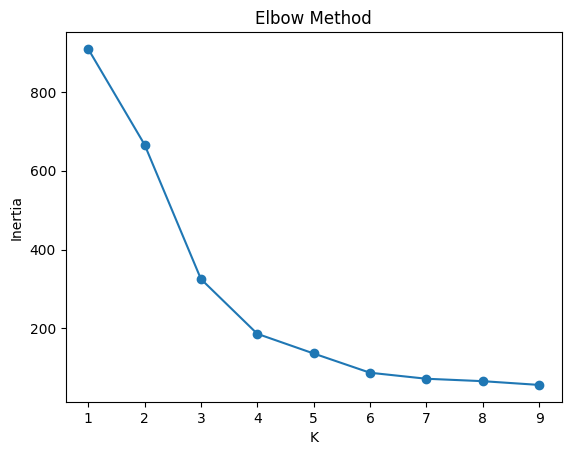

In [79]:
#Step 2: K-Means Segmentation
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_df[['Recency', 'Frequency', 'Monetary']])

# Elbow Method
inertia = []
for k in range(1, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(scaled_features)
    inertia.append(km.inertia_)

plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel("K")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

In [80]:
kmeans = KMeans(n_clusters=4, random_state=42)
customer_df['Cluster'] = kmeans.fit_predict(scaled_features)


In [81]:
# Step 3: Purchase Prediction 
# Create target: High spender
threshold = customer_df['Monetary'].median()
customer_df['HighSpender'] = (customer_df['Monetary'] > threshold).astype(int)

X = customer_df[['Recency', 'Frequency', 'Monetary']]
y = customer_df['HighSpender']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
}

In [82]:

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_test, preds))
    print("ROC-AUC:", roc_auc_score(y_test, preds))
    print("Precision:", precision_score(y_test, preds))
    print("Recall:", recall_score(y_test, preds))
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds))


Logistic Regression
Accuracy: 0.9836065573770492
ROC-AUC: 0.9838709677419355
Precision: 0.967741935483871
Recall: 1.0
Confusion Matrix:
 [[30  1]
 [ 0 30]]

Decision Tree
Accuracy: 1.0
ROC-AUC: 1.0
Precision: 1.0
Recall: 1.0
Confusion Matrix:
 [[31  0]
 [ 0 30]]

Random Forest
Accuracy: 0.9836065573770492
ROC-AUC: 0.9838709677419355
Precision: 0.967741935483871
Recall: 1.0
Confusion Matrix:
 [[30  1]
 [ 0 30]]


In [83]:

# Step 4: Product Recommendation 
from sklearn.metrics.pairwise import cosine_similarity

product_matrix = df.pivot_table(index='CustomerID', columns='Description', values='Quantity', fill_value=0)
similarity = cosine_similarity(product_matrix.T)  # Transpose for product-based

def recommend_products(product_name, n=5):
    if product_name not in product_matrix.columns:
        return "Product not found"
    idx = product_matrix.columns.get_loc(product_name)
    sim_scores = list(enumerate(similarity[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    top_products = [product_matrix.columns[i] for i, _ in sim_scores[1:n+1]]
    return top_products

print("\nRecommended Products:")
print(recommend_products("WHITE HANGING HEART T-LIGHT HOLDER"))


Recommended Products:
['PINK MARSHMALLOW SCARF KNITTING KIT', 'UNION JACK FLAG PASSPORT COVER ', 'LADS ONLY TISSUE BOX', 'EDWARDIAN PARASOL PINK', 'CREAM SLICE FLANNEL PINK SPOT ']
